### Imports 

In [1]:
import numpy as np
import pandas as pd
import json
#from dscribe.descriptors import CoulombMatrix
from ase import Atoms
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 22}

matplotlib.rc('font', **font)



In [2]:
def pad_with(vector, pad_width, iaxis, kwargs):
     pad_value = kwargs.get('padder', 10)
     vector[:pad_width[0]] = pad_value
     vector[-pad_width[1]:] = pad_value


def coulomb_matrix(atoms, n_atoms_max):
    # Creating a matrix with the product of the atomic numbers such that M_ij = Z[i]*Z[j]
    atomic_numbers = np.outer(atoms.get_atomic_numbers(),atoms.get_atomic_numbers())
    # Getting the distance matrix of the atoms object, such that element D_ij = |r_i - r_j|
    distances = atoms.get_all_distances()
    # Setting the diagonal elements, which are all zero, to 1 to avoid overflow errors
    np.fill_diagonal(distances, 1)
    
    # Creating the Cmat
    cmat = np.multiply(atomic_numbers, 1/distances) # Element wise multiplication
    np.fill_diagonal(cmat, 0.5*np.array(atoms.get_atomic_numbers())**2.4) # Filling the diagonal as described in the slides
    
    # Taking the sorted eigenvalues and padding with zeros such that all of the fingerprints have the same size
    shape = cmat.shape
    cmat,_ = np.linalg.eig(cmat)
    cmat = np.flip(np.sort(cmat))
    holder = np.zeros(n_atoms_max)
    holder[:shape[0]] = cmat
    cmat = holder
    
    return cmat



## Loading data and setting up the data frames

In [3]:
data_dir = "" # Specify your data path (Folder in which the files are placed)

In [4]:
# Loading the data as pandas DataFrame
train = pd.DataFrame(json.load(open(data_dir + "train.json", "rb")))
test = pd.DataFrame(json.load(open(data_dir + "test.json", "rb")))
## Transform atoms entry to ASE atoms object
train.atoms = train.atoms.apply(lambda x: Atoms(**x)) # OBS This one is important!
test.atoms = test.atoms.apply(lambda x: Atoms(**x))

In [5]:
print('Train data shape: {}'.format(train.shape))
train.head()

Train data shape: (2028, 5)


,formula,etot,dynamic_stability_level,atoms,Voigt_modulus
0,W2S2,-31.329664,1,"(Atom('W', [1.52711328, 0.8816792633, 9.115147...",80.175958
1,NiI2,-9.774512,2,"(Atom('Ni', [-7.814021732e-19, -1.673235808e-1...",31.358817
2,Ti3F2N2,-55.546656,1,"(Atom('Ti', [0.0, 0.0, 11.208358341], index=0)...",155.068663
3,Hf4N3O2,-85.216280,3,"(Atom('Hf', [0.0, 1.8605461437, 11.1322923235]...",279.073400
4,NbSTe,-19.876790,1,"(Atom('Nb', [1.26844161e-17, -3.001405002e-18,...",55.639070


In [6]:
train.atoms[1]

Atoms(symbols='NiI2', pbc=[True, True, False], cell=[[3.8508521418, -5.484107923e-19, 0.0], [-1.9254260709, 3.3349357811, 0.0], [1.332689519e-18, 0.0, 18.3890325946]])

In [7]:
print('Test data shape: {}'.format(test.shape))
test.head()

Test data shape: (264, 3)


,formula,etot,atoms
0,Ti2Te2,-21.567884,"(Atom('Te', [0.0001635792, 0.0005756553, 7.369..."
1,Cu2O2,-19.429111,"(Atom('Cu', [-3.606786318e-18, -0.0002926462, ..."
2,Y3C2,-33.214554,"(Atom('Y', [3.531761251e-18, -5.785592543e-18,..."
3,Ti2O4,-51.580206,"(Atom('Ti', [1.135647763e-19, 0.0301387729, 8...."
4,BiMoAs,-19.967820,"(Atom('Mo', [6.983934515e-18, 2.357780987e-16,..."


In [8]:
test.atoms[1]

Atoms(symbols='CuOCuO', pbc=[True, True, False], cell=[[2.8049685284, 1.734570062e-17, 0.0], [-3.746612841e-17, 5.602487274, 0.0], [-7.217855535e-18, 0.0, 16.9711719]])

In [9]:
np.unique(train.dynamic_stability_level,return_counts=True)

(array([1, 2, 3], dtype=int64), array([ 469,  538, 1021], dtype=int64))

## Creating the Coulomb matrix fingerprint
#### First a preprocessing step

In [10]:
species = []
number_of_atoms = []
atomic_numbers = []
for atom in pd.concat([train.atoms,test.atoms]):
    species = list(set(species+atom.get_chemical_symbols()))
    atomic_numbers = list(set(atomic_numbers+list(atom.get_atomic_numbers())))
    number_of_atoms.append(atom.get_number_of_atoms())

max_number_of_atoms = np.max(number_of_atoms)
min_atomic_number = np.min(atomic_numbers)
max_atomic_number = np.max(atomic_numbers)

print(max_number_of_atoms)

12


C:\software\anoconda\lib\site-packages\ase\atoms.py:971: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


#### Coulomb matrix

In [11]:
cmats = np.zeros((len(train),max_number_of_atoms))
for i,atoms in enumerate(train.atoms):
    if i%1000 == 0:
        print(i)
    cmat = coulomb_matrix(atoms,max_number_of_atoms)
    cmats[i,:] = cmat.flatten()
print(len(cmats))

0
1000
2000
2028


In [12]:
cmat.shape

(12,)

In [13]:
print(len(cmats), cmats.shape)

2028 (2028, 12)


# Setting target and feature vector

In [14]:
X = pd.DataFrame(data = cmats, index=train.index)
y = train['Voigt_modulus']
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (2028, 12)
y: (2028,)


## Splitting into test and train set

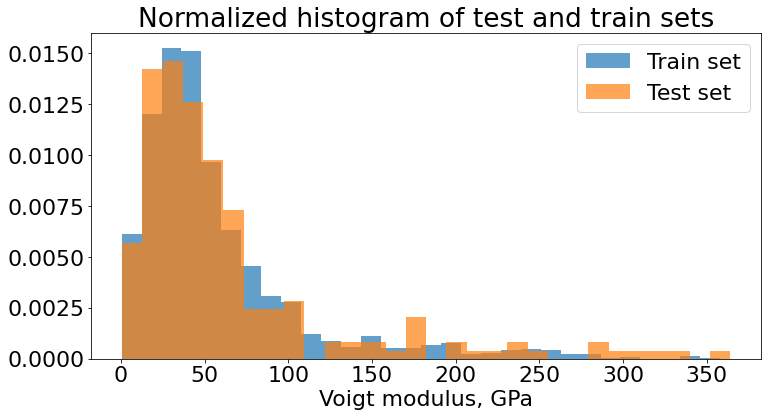

In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=250)

plt.figure(figsize = (12, 6))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.title("Normalized histogram of test and train sets")
plt.xlabel("Voigt modulus, GPa")
plt.legend()
plt.show()


In [16]:
print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))
print('X_test: {}'.format(X_test.shape))
print('y_test: {}'.format(y_test.shape))

X_train: (1825, 12)
y_train: (1825,)
X_test: (203, 12)
y_test: (203,)


# Guassian process

In [17]:
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
# from sklearn.preprocessing import StandardScaler

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [18]:
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [19]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# # Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# # Fit to data using Maximum Likelihood Estimation of the parameters
# gp.fit(X, y)

# # Make the prediction on the meshed x-axis (ask for MSE as well)

In [20]:
# X_train,X_test,y_train,y_test

In [21]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

# kernel = DotProduct() + WhiteKernel()
# gp = GaussianProcessRegressor(kernel=kernel, random_state=0)

# gp.fit(X_train, y_train)

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [23]:
print(X_train[:1])
print(X_test[:1])
print(y_train[:1])
print(y_test[:1])


[[-0.21538329  0.11997186 -0.2928659  -0.12466661 -0.34209483 -0.33491675
  -0.21328478 -0.21099065 -0.12583519 -0.11428706 -0.07845547 -0.07613841]]
[[ 1.94087712  2.3654149   1.85376736  2.46163971 -0.29840472 -0.30565057
  -0.21328478 -0.21099065 -0.12583519 -0.11428706 -0.07845547 -0.07613841]]
872    34.284621
Name: Voigt_modulus, dtype: float64
783    50.002928
Name: Voigt_modulus, dtype: float64


In [24]:
xp = X_train
tp = y_train
grid = X_test

In [25]:
class GP:
    "Class used for training and predicting using Gaussian process"
    def __init__ (self, l, k0, sigma): 
        self.l = l
        self.k0 = k0
        self.sigma = sigma
    def kernel(self, x, xx):
        "Calculates kernel"
        return self.k0*np.exp(-(np.sum((x-xx)**2))/(2*self.l**2))

    def kvec(self, x):
        "calculates k-vector, x  is grid values"
        kvec = np.array([self.kernel(x,xx) for xx in xp])
        return kvec
    
    def calc_K(self, xp):
        "Calculates K matrix. xp is samples x-values"
        K =  np.array([[self.kernel(x,xx) for x in xp] for xx in xp])
        return K
    
    def calc_C(self, xp):
        "Calculates C matrix. xp is sample x-values"
        K = self.calc_K(xp)
        C = K + self.sigma**2*np.identity(len(xp))
        return C
    
    def fitf(self, x, Cinvt):
        "returns k-vector dotted with C_inv dot sample-y"
        return np.dot(self.kvec(x), Cinvt)
    
    def varx(self, x, Cinv):
        "Calculates the variance. Used as descriptor for errousness"
        return self.kernel(x,x)-np.dot(self.kvec(x), np.dot(Cinv, self.kvec(x)))
    
    def train(self, xp):
        "xp is x-values of samples, tp is y-values of samples. Returns C invers and C invers dotted with t"
        C = self.calc_C(xp)
        return C
   
    def predict(self, xp, tp, grid):
        "xp is x-values of sample points, tp is y-values of sample points, grid is the grid to be fitted to"
        C = self.train(xp)
        Cinv = np.linalg.inv(C)
        Cinvt = np.dot(Cinv, tp)
        fit_array = np.array([self.fitf(x, Cinvt) for x in grid])
#         var_array = np.array([self.varx(x, Cinv) for x in X_test])
        return fit_array

In [26]:
# for i in [0.1, 0.5, 1, 3, 5]:
#     l = i
#     k0 = 0.5
#     sigma = 0.005
#     model = GP(l,k0,sigma)
#     train_prediction=model.predict(X_train, y_train, X_train)
#     test_prediction=model.predict(X_train, y_train, X_test)
#     print('Train RMSE = {:.12f}'.format(rmse(y_train,train_prediction)))
#     print('Test RMSE = {:.12f}'.format(rmse(y_test,test_prediction)))

In [27]:
# for j in [0.1, 0.3, 0.5, 1, 2, 3]:
#     l = 3
#     k0 = j
#     sigma = 0.005
#     model = GP(l,k0,sigma)
#     train_prediction=model.predict(X_train, y_train, X_train)
#     test_prediction=model.predict(X_train, y_train, X_test)
#     print('Train RMSE = {:.12f}'.format(rmse(y_train,train_prediction)))
#     print('Test RMSE = {:.12f}'.format(rmse(y_test,test_prediction)))

In [28]:
# for k in [0.0001, 0.0005, 0.0001, 0.001, 0.01, 0.1]:
#     l = 3
#     k0 = 3
#     sigma = k
#     model = GP(l,k0,sigma)
#     train_prediction=model.predict(X_train, y_train, X_train)
#     test_prediction=model.predict(X_train, y_train, X_test)
#     print('Train RMSE = {:.12f}'.format(rmse(y_train,train_prediction)))
#     print('Test RMSE = {:.12f}'.format(rmse(y_test,test_prediction)))

In [29]:
# for i in [0.1, 0.5, 1, 3, 5]:
#     for j in [0.1, 0.3, 0.5, 1, 2, 3]:
#         for k in [0.0001, 0.0005, 0.0001, 0.001, 0.01, 0.1]:
#             l = i
#             k0 = j
#             sigma = k
#             model = GP(l,k0,sigma)
#             train_prediction=model.predict(X_train, y_train, X_train)
#             test_prediction=model.predict(X_train, y_train, X_test)
#             print('i:',i,'j:', j,'k:', k)
#             print('Train RMSE = {:.12f}'.format(rmse(y_train,train_prediction)))
#             print('Test RMSE = {:.12f}'.format(rmse(y_test,test_prediction)))

In [30]:
# i: 1 j: 0.1 k: 0.01
# Train RMSE = 20.984680533183
# Test RMSE = 28.742369413241
l = 1
k0 = 0.1
sigma = 0.01
model = GP(l,k0,sigma)
train_prediction=model.predict(X_train, y_train, X_train)
test_prediction=model.predict(X_train, y_train, X_test)
print('Train RMSE = {:.12f}'.format(rmse(y_train,train_prediction)))
print('Test RMSE = {:.12f}'.format(rmse(y_test,test_prediction)))

Train RMSE = 21.935520580468
Test RMSE = 26.927755340055


In [31]:
print(len(train_prediction))
print(len(y_train))
print(len(test_prediction))
print(len(y_test))

1825
1825
203
203


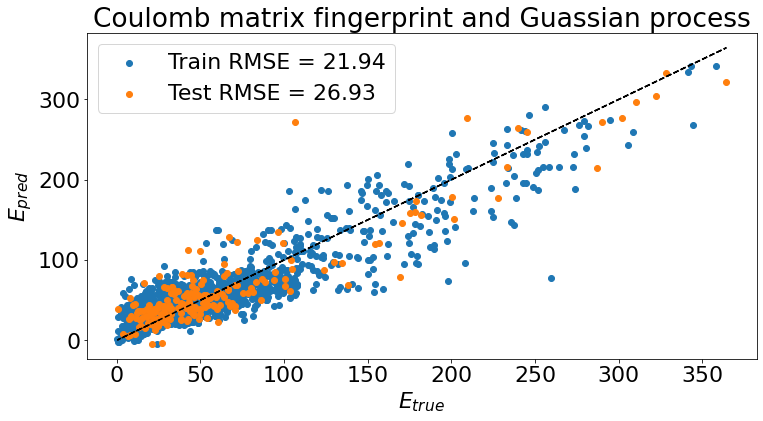

In [32]:
fig = plt.figure(figsize = (12, 6))

plt.title("Coulomb matrix fingerprint and Guassian process")
plt.scatter(y_train, train_prediction , label = 'Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
plt.scatter(y_test, test_prediction, label = 'Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))
plt.plot(y_test, y_test, linestyle = "--", color = "k")
plt.xlabel("$E_{true}$")
plt.ylabel("$E_{pred}$")
plt.legend()
plt.show()

# Prepare submission to Kaggle

In [41]:
cmats_test = np.zeros((len(test),max_number_of_atoms))
for i,atoms in enumerate(test.atoms):
    if i%1000 == 0:
        print(i)
    cmat = coulomb_matrix(atoms,max_number_of_atoms)
    cmats_test[i,:] = cmat.flatten()
print(len(cmats))

0
2028


In [42]:
X_test_kaggle = pd.DataFrame(data = cmats_test, index=test.index)
X_test_kaggle.loc[:,:] = scaler.transform(X_test_kaggle)
print(X_test_kaggle[:1])

         0         1         2         3         4         5         6   \
0 -0.270586  0.064734 -0.466293 -0.270297 -0.342095 -0.334917 -0.213285   

         7         8         9         10        11  
0 -0.210991 -0.125835 -0.114287 -0.078455 -0.076138  


In [43]:
from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler().fit(X_test_kaggle)
X_test_kaggle = scaler2.transform(X_test_kaggle)
print(X_test_kaggle[:1])

[[-0.0388791   0.44798571 -0.36085988 -0.1132343  -0.29312789 -0.28716728
  -0.13829402 -0.13606069 -0.15913802 -0.14986892 -0.12373053 -0.12383767]]


In [44]:
# test_prediction_dataframe = pd.DataFrame(data = {'ID':test.index,
#                                                  'Voigt_modulus':model.predict(X_test_kaggle)})
test_prediction_dataframe = pd.DataFrame(data = {'ID':test.index,
                                                 'Voigt_modulus':model.predict(X_train, y_train, X_test_kaggle)})
test_prediction_dataframe.head()

,ID,Voigt_modulus
0,0,72.309690
1,1,97.636548
2,2,203.345186
3,3,101.652938
4,4,73.758931


In [46]:
test_prediction_dataframe.to_csv(data_dir+'submission_test.csv',index=False)